In [2]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import re

import pandas as pd

#can comment this in and out to make interactable
#%matplotlib widget

# Use our custom style and colours
plt.style.use('shendrukGroupStyle')
import shendrukGroupFormat as ed

from matplotlib.animation import FFMpegWriter, PillowWriter, HTMLWriter
from matplotlib.collections import LineCollection

from jones import *

In [91]:
class polyAnalyser():
    def __init__(self, polyDataFileName, simLength, fluidDataFileName=None):
        self.polyDataFileName = polyDataFileName
        self.simLength = simLength
        self.fluidDataFileName = fluidDataFileName
        
        #extract the polymer data
        with open(self.polyDataFileName, 'r') as f:
            lines = f.readlines()
    
        #Skip header lines (first 82 lines, read empirally)
        data_lines = [line for line in lines[82:] if line.strip()]

        data = []
        current_t = 0.0
        timestep_increment = 0.1

        for line in data_lines:
            # Replace multiple spaces/tabs with single space and split
            cleaned_line = re.sub(r'\s+', ' ', line.strip())
            parts = cleaned_line.split(' ')
            
            # Check if this is a "timestep indexed" line (start of new block)
            if len(parts) >= 2 and parts[0] == 'timestep' and parts[1] == 'indexed':
                # Increment timestep for the next block
                current_t = round(current_t + timestep_increment, 10)
                continue  # Skip this header line
            
            # Process data lines (monomer index, x, y, z)
            if len(parts) >= 4:
                try:
                    data.append({
                        't': current_t,
                        'monomerIndex': int(parts[0]),
                        'x': float(parts[1]),
                        'y': float(parts[2]),
                        'z': float(parts[3]),
                    })
                except ValueError:
                    # Skip lines that can't be parsed as numbers
                    continue
    
        self.polyData=pd.DataFrame(data)
    

    def makeMovie(self, axesLim):
        writer = FFMpegWriter(fps=10, bitrate=10000)
        output_file = 'particle_animation.mp4'

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(projection='3d')

        


        with writer.saving(fig, output_file, dpi=100):
            #currenlty not reading these values automatically, just reading from input.json myself
            for i in range(0, self.simLength+1):
                #calculate t value from i (dividing instead of multiplying as avoids floating point errors)
                t=i/10

                print('Currenlty processing frame at t = ', t)

                #fluid processing
                # x=data[data['t']==t]['qx']
                # y=data[data['t']==t]['qy']
                # z=data[data['t']==t]['qz']

                #monomerInfo
                monomerData = self.polyData[self.polyData['t'] == t].sort_values('monomerIndex') #new line
                monoX=self.polyData[self.polyData['t']==t]['x']
                monoY=self.polyData[self.polyData['t']==t]['y']
                monoZ=self.polyData[self.polyData['t']==t]['z']

                #clear previous frame
                ax.clear()

                if len(monoX) > 1:
                    # Create rainbow colors for each segment
                    colors = plt.cm.rainbow(np.linspace(0, 1, len(monoX) - 1))
                    
                    # Plot each segment between monomers with different color
                    for j in range(len(monoX) - 1):
                        ax.plot(monoX[j:j+2], monoY[j:j+2], monoZ[j:j+2],
                            color=colors[j], linewidth=3, alpha=0.8)
                    
                    # Add monomer points with matching colors
                    point_colors = plt.cm.rainbow(np.linspace(0, 1, len(monoX)))
                    ax.scatter(monoX, monoY, monoZ, c=point_colors, s=40, alpha=1,
                            edgecolors='black', linewidth=0.5)

                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                ax.set_zlabel('Z')
                ax.set_xlim([0, axesLim])
                ax.set_ylim([0, axesLim])
                ax.set_zlim([0, axesLim])

                ax.set_title(f'Particle Positions at t = {t:.1f}')

                writer.grab_frame()
    

    #plots and returns data if you want to compare several simulations
    def plotAvgMonomerSpeeds(self):
        avgSpeedData=[]
        #loop between second and last-1 time frame 
        for i in range(2, self.simLength):
                #calculate t value from i (dividing instead of multiplying as avoids floating point errors)
                t=i/10
                tPrev=(i-1)/10

                dt=t-tPrev

                #previous monomerInfo
                monomerData = self.polyData[self.polyData['t'] == tPrev].sort_values('monomerIndex') #new line
                prevMonoX=self.polyData[self.polyData['t']==tPrev]['x']
                prevMonoY=self.polyData[self.polyData['t']==tPrev]['y']
                prevMonoZ=self.polyData[self.polyData['t']==tPrev]['z']

                #monomerInfo
                monomerData = self.polyData[self.polyData['t'] == t].sort_values('monomerIndex') #new line
                monoX=self.polyData[self.polyData['t']==t]['x']
                monoY=self.polyData[self.polyData['t']==t]['y']
                monoZ=self.polyData[self.polyData['t']==t]['z']

              
                #print(monoX.values - prevMonoX.values, 'difference in X for 1 timestep  ')

                #calculate speeds
                speeds=np.sqrt((monoX.values - prevMonoX.values)**2 + (monoY.values - prevMonoY.values)**2 + (monoZ.values - prevMonoZ.values)**2)/dt
                #print(speeds, 'speeds')
                avgSpeed=np.mean(speeds)
                avgSpeedData.append(avgSpeed)
        
        plt.plot(range(self.simLength-2), avgSpeedData)
        plt.xlabel('Time step')
        plt.ylabel('Average monomer speed')
        plt.title('Average Monomer Speed vs Time')
        plt.show()

        return avgSpeedData

    def getUnknotTime(self):
        #loop through simulation timesteps

        #originally looped through backwards to try and avoid checking all early timesteps, but if monomer has funky blow up conditions, checker doesn't like
        for i in range(1,self.simLength):
        #for i in range(1, 10):
            t=i/10
            #print(t)
            monomerData = self.polyData[self.polyData['t'] == t].sort_values('monomerIndex')
            
            #get coord data for checking
            monoX=self.polyData[self.polyData['t']==t]['x']
            monoY=self.polyData[self.polyData['t']==t]['y']
            monoZ=self.polyData[self.polyData['t']==t]['z']

            #print(monoX)

            #put coordinates into format
            coordinates = np.column_stack([monoX, monoY, monoZ])
            jonesInput = np.array([coordinates], dtype=object)

            #print(jonesInput)

            #calculating
            jonesPolynomial=expected_jones(jonesInput, 1)

            #print(jonesPolynomial, 'jonespoly')

            
            #check if unknotting
            if jonesPolynomial== {0: np.float64(1.0)}:
                print(jonesPolynomial, 'found unknotting at t= ', t)

                #threshold for false positives at early time dynamics, value is empirical and should think harder about this
                if t<2:
                    pass
                else:
                    unknotTime=t
                    break
        
        return unknotTime




In [92]:
#length is 1500, but set to 150 now to speed things up 
a=polyAnalyser('/Users/johnwhitfield/Desktop/firstParallelBashSim/output/XYZ_knot3_1.n24.480000_output/20251111-58849/20251111-58849-vmd.vtf', 150)
#a.makeMovie(7)
unKnotTime=a.getUnknotTime()

print(unKnotTime)


{0: np.float64(1.0)} found unknotting at t=  4.8
4.8


In [93]:
#length is 1500, but set to 150 now to speed things up 
a=polyAnalyser('/Users/johnwhitfield/Desktop/firstParallelBashSim/output/XYZ_knot3_1.n24.540000_output/20251111-58872/20251111-58872-vmd.vtf', 150)
#a.makeMovie(7)
unKnotTime=a.getUnknotTime()

print(unKnotTime)

{0: np.float64(1.0)} found unknotting at t=  0.2
{0: np.float64(1.0)} found unknotting at t=  0.5
{0: np.float64(1.0)} found unknotting at t=  9.8
9.8


In [94]:
#length is 1500, but set to 150 now to speed things up 
a=polyAnalyser('/Users/johnwhitfield/Desktop/firstParallelBashSim/output/XYZ_knot3_1.n24.120000_output/20251111-58986/20251111-58986-vmd.vtf', 150)
#a.makeMovie(7)
unKnotTime=a.getUnknotTime()

print(unKnotTime)

{0: np.float64(1.0)} found unknotting at t=  7.0
7.0


In [99]:
import os 
import glob
import re  # Add this import

def process_all_simulations_simple():
    base_dir = "/Users/johnwhitfield/Desktop/firstParallelBashSim/output"

    unKnotTimes=[]
    
    # Get all simulation directories
    sim_dirs = glob.glob(os.path.join(base_dir, "XYZ_knot3_1.n24.*_output"))
    
    # Better sorting using regex to extract the number
    def extract_number(path):
        # Match the number after the last dot and before _output
        match = re.search(r'\.(\d+)_output', path)
        if match:
            return int(match.group(1))
        return 0  # Default if no match
    
    sim_dirs_sorted = sorted(sim_dirs, key=extract_number)
    
    print(f"Found {len(sim_dirs_sorted)} simulation directories")
    
    for sim_dir in sim_dirs_sorted:
        # Extract the simulation parameter using regex
        match = re.search(r'\.(\d+)_output', sim_dir)
        if match:
            sim_param = match.group(1)
        else:
            sim_param = "unknown"
            
        print(f"\nProcessing: {sim_param}")
        
        # Find the timestamp subdirectory
        for item in os.listdir(sim_dir):
            item_path = os.path.join(sim_dir, item)
            if os.path.isdir(item_path) and item.replace('-', '').isdigit():
                vtf_file = os.path.join(item_path, f"{item}-vmd.vtf")
                if os.path.exists(vtf_file):
                    #print(f"  Analyzing: {vtf_file}")
                    try:
                        a = polyAnalyser(vtf_file, 150)
                        unknot_time = a.getUnknotTime()
                        unKnotTimes.append(unknot_time)
                        print(f"  Unknot time: {unknot_time}")
                    except Exception as e:
                        print(f"  ERROR: {e}")
                        #assign some conventional value of -1 for no unknotting detected
                        unKnotTimes.append(-1)
                    break  # Only process first matching directory
                else:
                    print(f"  VTF file not found: {vtf_file}")
        else:
            print(f"  No timestamp directory found in {sim_dir}")

    return unKnotTimes
        


unknotTimes=process_all_simulations_simple()

Found 30 simulation directories

Processing: 20000
{0: np.float64(1.0)} found unknotting at t=  12.4
  Unknot time: 12.4

Processing: 40000
{0: np.float64(1.0)} found unknotting at t=  4.8
  Unknot time: 4.8

Processing: 60000
{0: np.float64(1.0)} found unknotting at t=  4.2
  Unknot time: 4.2

Processing: 80000
{0: np.float64(1.0)} found unknotting at t=  8.0
  Unknot time: 8.0

Processing: 100000
  ERROR: cannot access local variable 'unknotTime' where it is not associated with a value

Processing: 120000
{0: np.float64(1.0)} found unknotting at t=  6.9
  Unknot time: 6.9

Processing: 140000
{0: np.float64(1.0)} found unknotting at t=  2.7
  Unknot time: 2.7

Processing: 160000
{0: np.float64(1.0)} found unknotting at t=  1.6
{0: np.float64(1.0)} found unknotting at t=  5.7
  Unknot time: 5.7

Processing: 180000
{0: np.float64(1.0)} found unknotting at t=  3.8
  Unknot time: 3.8

Processing: 200000
  ERROR: cannot access local variable 'unknotTime' where it is not associated with a v

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/r2/ssbd733d3y7cqh5q583b4wbw0000gn/T/ipykernel_61698/372165915.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$t_\mathrm{unknot}$')


[12.4, 4.8, 4.2, 8.0, -1, 6.9, 2.7, 5.7, 3.8, -1, 2.6, 7.9, 10.2, 3.3, 8.3, 7.2, 11.7, 14.9, 7.2, 4.0, 2.4, 6.1, 4.2, 4.8, 3.0, 3.9, 5.0, 3.5, -1, 7.0]


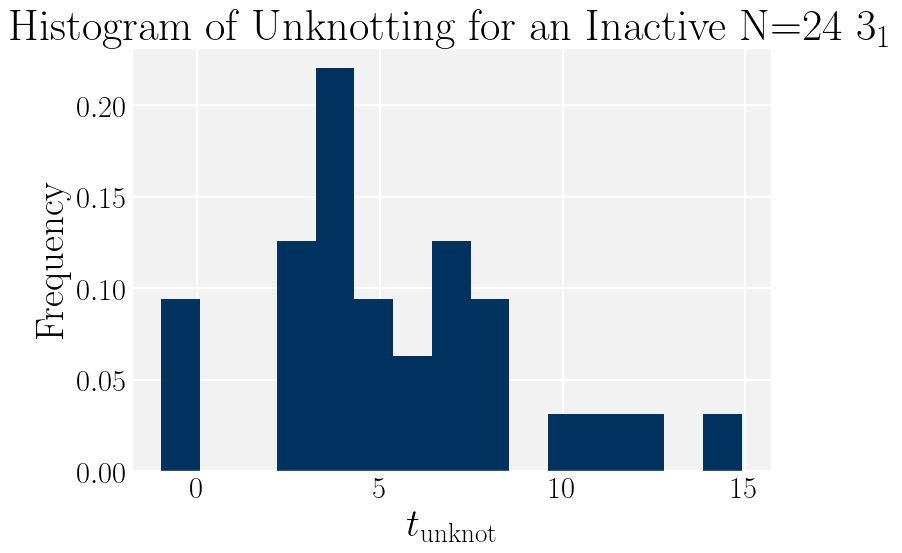

In [112]:
print(unknotTimes)

plt.hist(unknotTimes, bins=len(unknotTimes)//2, density=True)
plt.xlabel('$t_\mathrm{unknot}$')
plt.ylabel('Frequency')
plt.title('Histogram of Unknotting for an Inactive N=24 $3_1$')
plt.show()